In [1]:
# Parameters
DatasetID = "DS000017726"
DEV = False
test_DatasetID = ""
DS_test = False
title = "Recursion DLD1 Library3- Screen2 (NGS5888)"
description = "Production scale screen in DLD-1 cells with 1/4 of the genome-wide CRISPR library (sub-lib-3, ~22K guides). 1 time point: Day-5. We performed 24 rxns of 10x 3' HT kit with an estimated loading of 52K cells. We performed a pilot study to test the library quality before the production-level sequencing. We will submit 72 libraries (24 GEX, 24 HTO and 24 sgRNA) We request 600M reads for GEX, 20M for HTO and 40M for sgRNA, after finishing QC sequencing of NGS5887. NGS has built the GEX and sgRNA libraries using automation, we will provide manually constructed HTO libraries."
name_space = [{"id": "GRCh38", "type": "genome"}]
sources = [{"id": "Siavash-1234", "name": "Geo-ID"}]
tech_name = "scRNA-seq"
author = "SG"
alt_experiments = ["crispr", "hashing"]
organism = "human"
experiment = "hashing"
topBarcodesToPlot = 5
bottomBarcodesToPlot = 5
fix_barcodes = False
valid_assignments = None


# QC analysis of single cell barcode dataset: This notebook will guide you through the process of quality control analyis on a single-cell RNA sequencing barcode dataset

In [2]:
# Different scenario for original dataset or test dataset
if DS_test==True:
    DSID = test_DatasetID
    Version = '2'   # the version of your dataset
    DEV = True
elif len(alt_experiments)==2:
    DSID = DatasetID
    Version = '4'   # the version of your dataset
    your_experiment = "crispr_hashing_harmonized" # A string that is a key known for our desired experimnet that you wish to work on
else:
    DSID = DatasetID
    Version = '2'   # the version of your dataset
    your_experiment = "main" # A string that is a key known for our desired experimnet that you wish to work on

New_experiment = "raw_qc" # A string that is a key known for the updated data saved by that that name
min_counts_cutoff = 2
min_margin = 3

In [3]:
## Import Libraries

from __future__ import division
%matplotlib inline 

#single cell libraries
import scanpy as sc


#general
import pandas as pd
import sys, os
import numpy as np
import scipy
from scipy import stats
import itertools
from glob import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import OrderedDict 
from scipy.stats import zscore

#plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append("..")
import Templates.tools.DatasetDB as DB
import Templates.tools.scBarcodeProc as Bproc
import Templates.tools.Barcode_Count_QC as bar

In [5]:
%load_ext autoreload
%autoreload 2

## Instantiate a dataset object given our dataset info

In [6]:
DS = DB.DATASET(DSID, DEV, title=title, description=description, name_space=name_space, organism=organism,
                       sources=sources, tech_name=tech_name, author=author)

In [7]:
adata, adatas = DS.load_dataset(Version, your_experiment, Corr=False)


12:44:56 -> Collating dataset: 'DS000017726' metadata.
12:44:56 -> Retrieving all project: 'DS000017726@4' metadata.



12:44:57 -> Reading: 'DS000017726'.

12:44:57 -> Reading: 'DS000017726 -> Experiment: main'.

12:44:57 -> Reading: 'DS000017726 -> Experiment: main -> Alt. Exp.: crispr'.

12:44:57 -> Reading: 'DS000017726 -> Experiment: main -> Alt. Exp.: hashing'.



12:44:59 -> Reading: 'DS000017726 -> Experiment: crispr_hashing_harmonized'.

12:44:59 -> Reading: 'DS000017726 -> Experiment: crispr_hashing_harmonized -> Alt. Exp.: crispr'.

12:44:59 -> Reading: 'DS000017726 -> Experiment: crispr_hashing_harmonized -> Alt. Exp.: hashing'.


In [8]:
adata.obs['Sample'] = adata.obs['Sample']+"_rep"+adata.obs['10Xrun']

In [9]:
adata = bar.adata_cleaner (adata, adatas, experiment=experiment, fix_barcodes=fix_barcodes, alt_experiments=alt_experiments)

In [10]:
adata

AnnData object with n_obs × n_vars = 105815 × 19
    obs: 'Sample', 'Barcode', 'demux_type', 'assignment'
    uns: '.internal'
    layers: 'counts'

In [11]:
adata.obs.head()

,Sample,Barcode,demux_type,assignment
SAM24456643_rep17-AAACCCAAGAAGCGCT,SAM24456643_rep17,AAACCCAAGAAGCGCT,unknown,unknown
SAM24456643_rep17-AAACCCAAGAGGTATT,SAM24456643_rep17,AAACCCAAGAGGTATT,singlet,SAM24439045
SAM24456643_rep17-AAACCCAAGCATGATA,SAM24456643_rep17,AAACCCAAGCATGATA,singlet,SAM24439044
SAM24456643_rep17-AAACCCAAGCGTTGTT,SAM24456643_rep17,AAACCCAAGCGTTGTT,singlet,SAM24439043
SAM24456643_rep17-AAACCCAAGGCACCAA,SAM24456643_rep17,AAACCCAAGGCACCAA,singlet,SAM24439044


## Margin vs. DemuxEM

In [12]:
# process array
df = Bproc.proc_array(adata, key=experiment)

In [13]:
# assign identities
df = Bproc.assign_gRNA_identity(df=df, key=experiment, min_counts_cutoff=min_counts_cutoff, min_margin=min_margin)

In [14]:
df = adata.obs.join(df)

In [15]:
df_g = df.copy()
df_g=df_g.rename(columns={"demux_type":f'DemuxType_{experiment}'})
df_p = pd.crosstab(df_g[f'marginType_{experiment}'], df_g[f'DemuxType_{experiment}'])

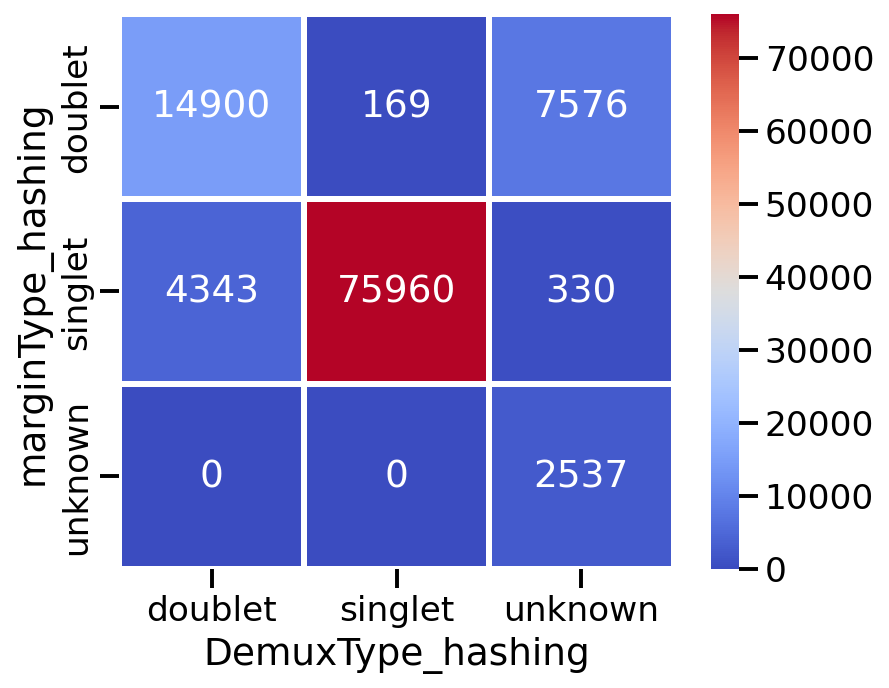

In [16]:
with plt.rc_context({"figure.dpi": (150)}):
    sns.heatmap(df_p, square=True, cmap='coolwarm', linewidths=2, linecolor='white', annot=True, fmt='g')

## Basic Counts

In [17]:
Bproc.count_features(adata, ['Sample'])

,Sample,cnt,pct
0,SAM24456643_rep17,25944,100.0
1,SAM24456643_rep18,24453,100.0
2,SAM24456643_rep19,23082,100.0
3,SAM24456643_rep20,32336,100.0


In [18]:
adata.obs["demux_type"]=adata.obs["demux_type"].fillna("unknown")

In [19]:
agg = Bproc.count_features(adata, ['Sample', 'demux_type'])
agg = pd.pivot_table(agg, values='pct', index=['Sample'], columns=['demux_type'])

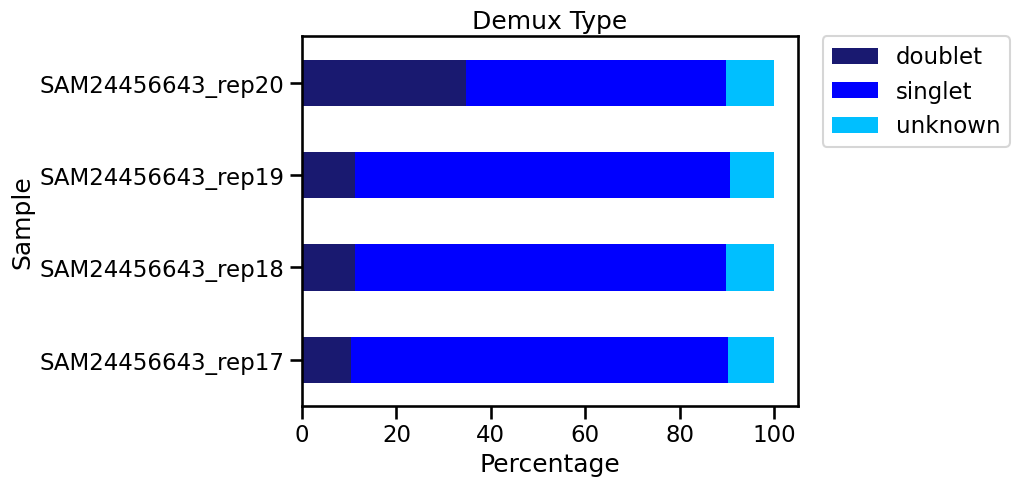

In [20]:
agg.plot(kind='barh', stacked=True, color=['midnightblue', 'blue', 'deepskyblue'])
plt.title('Demux Type')
plt.xlabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

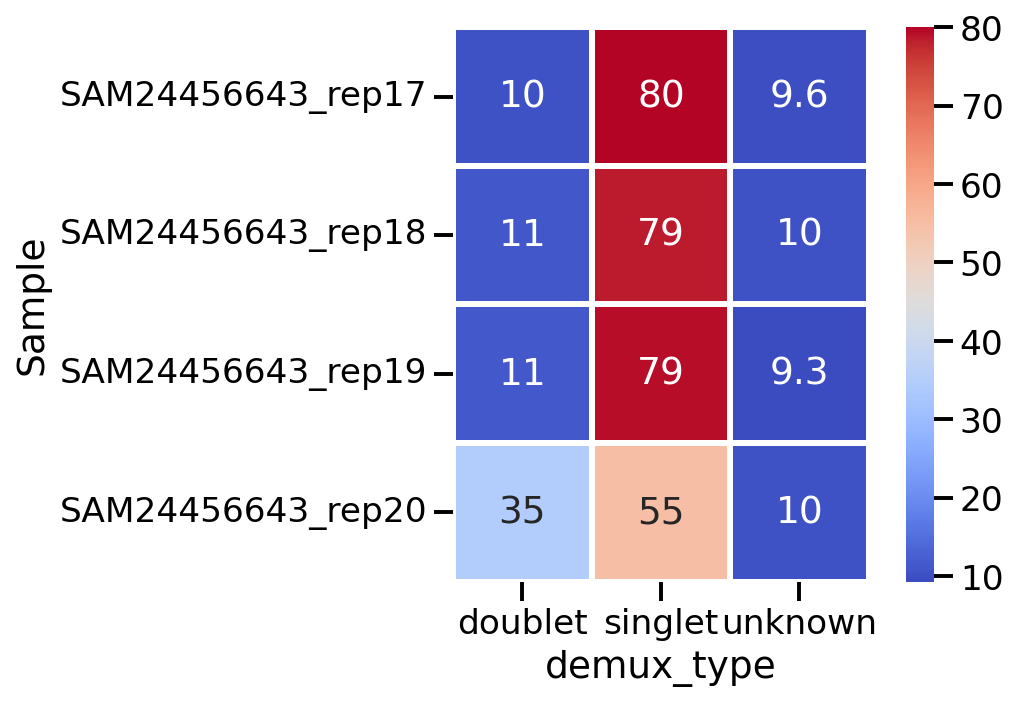

In [21]:
with plt.rc_context({"figure.dpi": (150)}):
    sns.heatmap(agg, square=True, cmap='coolwarm', linewidths=2, linecolor='white', annot=True)

In [22]:
if fix_barcodes == True:
    demux_singlet = 'valid_doublet'
else:
    demux_singlet = 'singlet'
    demux_doublet = 'doublet'
    
singlets = Bproc.count_features(adata[(adata.obs['demux_type']==demux_singlet).astype('bool')], ['assignment']).sort_values(by='cnt', ascending=False)
doublets = Bproc.count_features(adata[(adata.obs['demux_type']==demux_doublet).astype('bool')], ['assignment']).sort_values(by='cnt', ascending=False)

In [23]:
singlets

,assignment,cnt,pct
2,SAM24439044,29455,100.0
3,SAM24439045,24134,100.0
1,SAM24439043,22535,100.0
0,POSITIVE_CONTROL,5,100.0


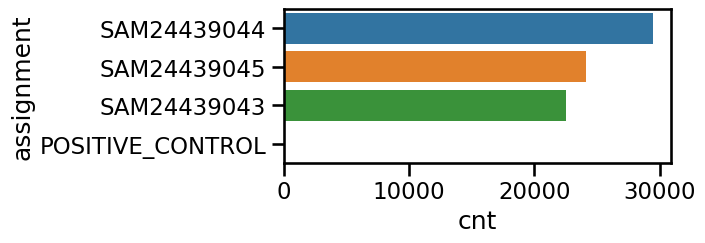

In [24]:
if experiment == "crispr":
    f, ax = plt.subplots(figsize=(5, len(singlets.head(20))*0.5))
    sns.barplot(data=singlets.head(20), y='assignment', x='cnt')
else:
    f, ax = plt.subplots(figsize=(5, len(singlets)*0.5))
    sns.barplot(data=singlets, y='assignment', x='cnt')

In [25]:
if experiment == "crispr":
    adata = adata[:,adata.var_names.isin(singlets.head(5000)["assignment"].tolist())]
    adata.layers['counts'] = adata.layers['counts'].astype("float32")

###  Select top barcodes raw data

In [26]:
topBC = adata.to_df().mean().sort_values(ascending=False).index.tolist()[:topBarcodesToPlot]
bottomBC = adata.to_df().mean().sort_values(ascending=False).index.tolist()[-bottomBarcodesToPlot:]

##  Center log ratio normalization and embedding

In [27]:
adata = Bproc.procBC(adata, n_pcs=50, n_neighbors=10)

applying center log ratio


computing pca
computing neighbors


computing umap


## Plot top barcodes normalized data

In [28]:
df = Bproc.meltdf(adata, topBC)
df.columns = ['BC', 'value']

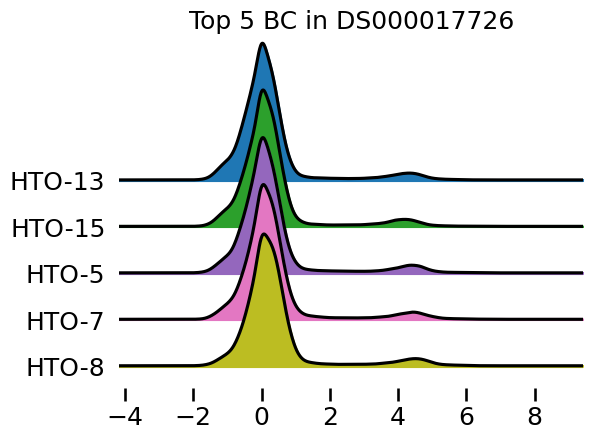

In [29]:
if topBarcodesToPlot >5:
    Bproc.plot_ridge(df, title='Top ' + str(topBarcodesToPlot) + ' BC in ' + DSID, 
                    figsize=(5, (topBarcodesToPlot*0.9)))
    
else:
    Bproc.plot_ridge(df, title='Top ' + str(topBarcodesToPlot) + ' BC in ' + DSID,
                    xlim='own')

## Repaet for only singlets

In [30]:
df = Bproc.meltdf(adata[(adata.obs['demux_type']==demux_singlet).astype('bool')], topBC)
df.columns = ['BC', 'value']

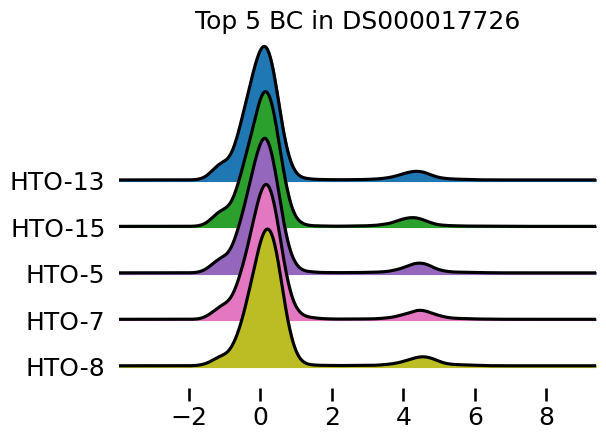

In [31]:
 if topBarcodesToPlot >5:
    Bproc.plot_ridge(df, title='Top ' + str(topBarcodesToPlot) + ' BC in ' + DSID, 
                    figsize=(5, (topBarcodesToPlot*0.9)))
    
else:
    Bproc.plot_ridge(df, title='Top ' + str(topBarcodesToPlot) + ' BC in ' + DSID,
                    xlim='own')

##  Plot bottom barcodes normalized data

In [32]:
df = Bproc.meltdf(adata, bottomBC)
df.columns = ['BC', 'value']

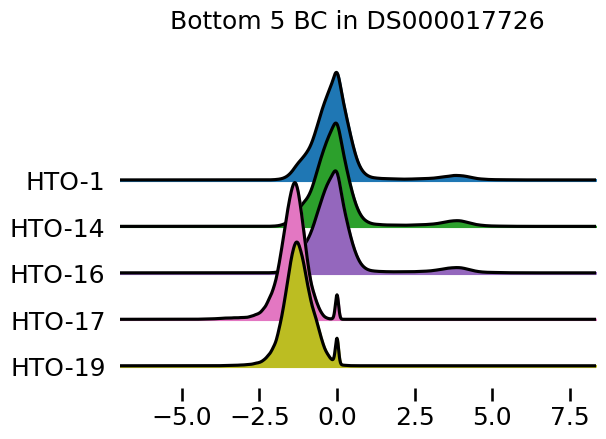

In [33]:
 if bottomBarcodesToPlot >5:
    Bproc.plot_ridge(df, title='Bottom ' + str(bottomBarcodesToPlot) + ' BC in ' + DSID, 
                    figsize=(5, (topBarcodesToPlot*0.9)))
    
else:
    Bproc.plot_ridge(df, title='Bottom ' + str(bottomBarcodesToPlot) + ' BC in ' + DSID)

## Dot Plots

### Singlets

In [34]:
var_order = adata[(adata.obs['demux_type']==demux_singlet).astype('bool')].var_names.tolist()
var_order.sort()

cat_order = adata[(adata.obs['demux_type']==demux_singlet).astype('bool')].obs['assignment'].unique().tolist()
if experiment == 'crispr':
    cat_order.sort()

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/anndata/_core/anndata.py:1276: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


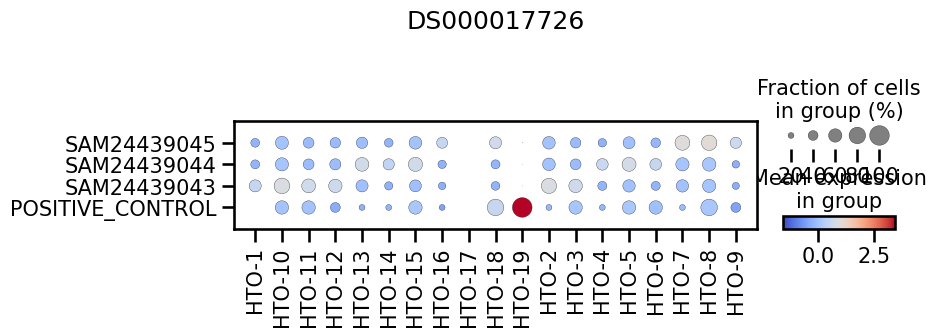

In [35]:
if experiment == 'hashing':
    sc.pl.dotplot(adata[(adata.obs['demux_type']==demux_singlet).astype('bool')], var_names=var_order, 
              groupby='assignment', categories_order=cat_order,
              cmap='coolwarm', title=DSID)

## UMAP visualizations

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


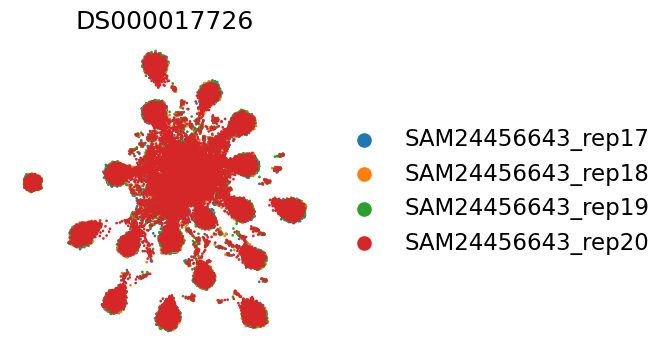

In [36]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
    sc.pl.umap(adata, color=['Sample'], s=15, frameon=False, title=DSID)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


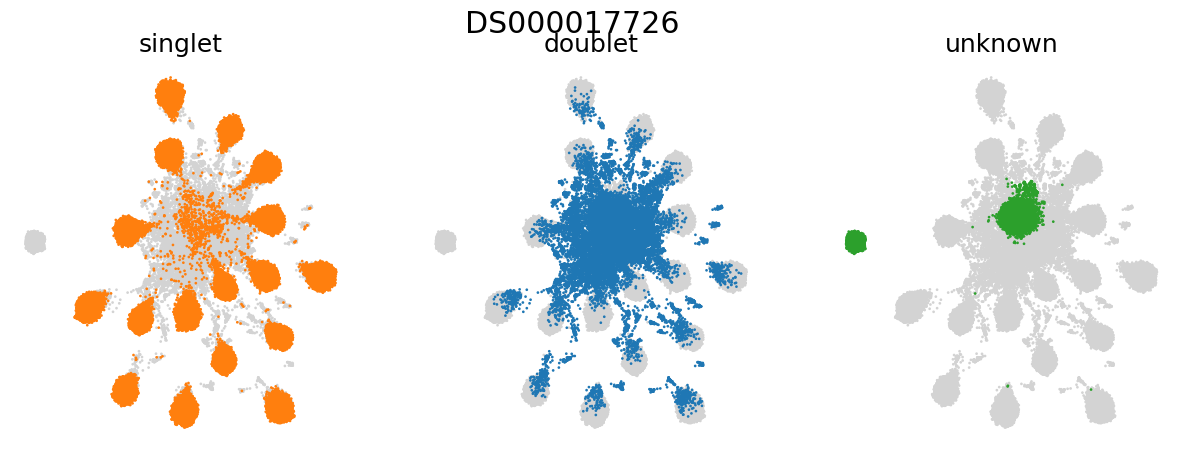

In [37]:
with plt.rc_context({"figure.dpi": (100)}):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    sc.pl.umap(adata, color=['demux_type'], s=15, frameon=False, groups=[demux_singlet], show=False, legend_loc='', title=demux_singlet, ax=ax1)
    sc.pl.umap(adata, color=['demux_type'], s=15, frameon=False, groups=['doublet'], show=False, legend_loc='', title='doublet', ax=ax2)
    sc.pl.umap(adata, color=['demux_type'], s=15, frameon=False, groups=['unknown'], show=False, legend_loc='', title='unknown', ax=ax3)
    f.suptitle(DSID, y=0.98)

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


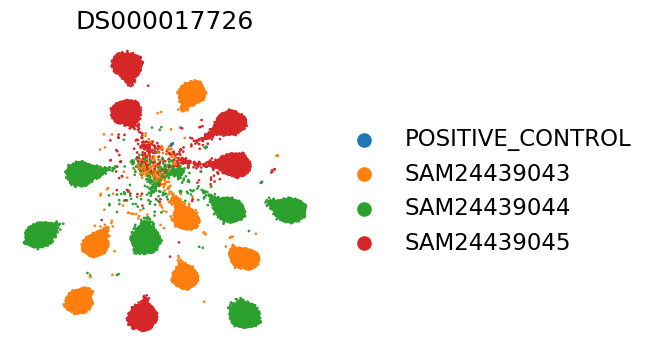

In [38]:
if experiment == 'hashing':
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
        sc.pl.umap(adata[adata.obs['demux_type']==demux_singlet], color=['assignment'], s=15, frameon=False, title=DSID)

### Top BC

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


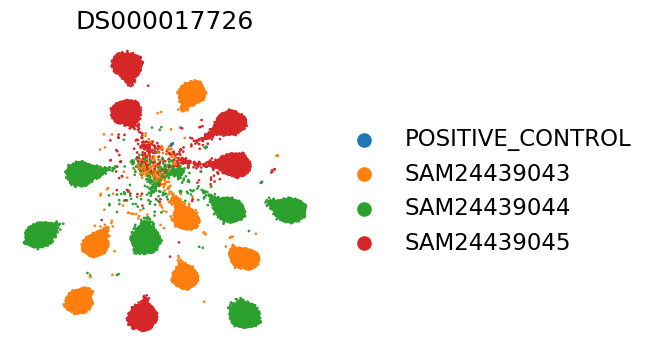

In [39]:
if experiment == 'hashing':
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
        sc.pl.umap(adata[adata.obs['demux_type']==demux_singlet], color=['assignment'], s=15, 
               frameon=False, groups=singlets.assignment.tolist()[:topBarcodesToPlot], title=DSID)

### bottom 5

/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/apps/user/gpy/envs/dev/GPUy310pascal/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


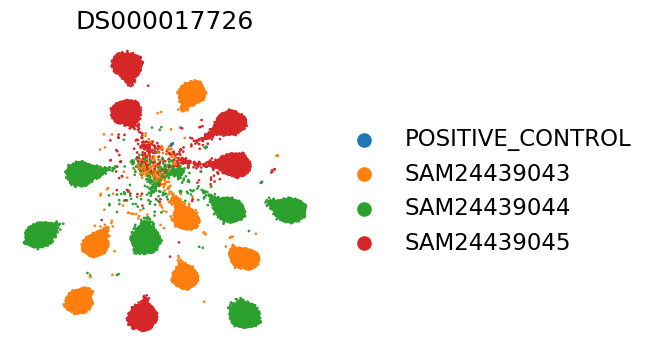

In [40]:
if experiment == 'hashing':
    with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (100)}):
        sc.pl.umap(adata[adata.obs['demux_type']==demux_singlet], color=['assignment'], s=15, 
               frameon=False, groups=singlets.assignment.tolist()[bottomBarcodesToPlot:], title=DSID)

## View Anndata object

In [41]:
adata

AnnData object with n_obs × n_vars = 105815 × 19
    obs: 'Sample', 'Barcode', 'demux_type', 'assignment'
    uns: '.internal', 'pca', 'neighbors', 'umap', 'Sample_colors', 'demux_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'